# Mixture Models 

Here we review and implement typical mxiture models such as k-means, and Gaussian Mixture Models.

## Gaussian Mixture

The main purpose of Gaussian mixture model is to estimate the density of a given data set. 
Gaussian mixture model assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.
One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

Each of the Gaussian component represents a cluster. Every data point is generated by one of the Gaussian distributions in the mixture model.

- Given data $X = \{x_1,x_2, ..., x_N\}$, where $x_i \in R^D$. Assume the data can be clustered into K clusters, and each cluster is a Gaussian distribution with mean $\mu_k$ and covariance $\Sigma_k$. We want to know the marginal probability of each data point $x_i$, or $P(X)$.

    - introduce a latent multinomial variable $z = \{z_1, ..., z_K \}$, where $z_k = \{0, 1\}$, and $\sum_{k=1}^{K}z_k = 1$. $z_k$ indicates which cluster $x_i$ belongs to. $z_k = 1$ means $x_i$ belongs to cluster $k$.
    - $p(z_k = 1) = \pi_k$, where $\pi_k$ is the prior probability of cluster $k$.  $\sum_{k=1}^{K} \pi_k = 1$. Thus, $p(z) = \Pi_{k=1}^{K} \pi_k^{z_k}$.
    - $p(x|z_k = 1) = \mathcal N (x_i|\mu_k, \Sigma_k)$, where $\mathcal N (x|\mu_k, \Sigma_k)$ is the Gaussian distribution with mean $\mu_k$ and covariance $\Sigma_k$.
    - the conditional distribution is then $p(x|z) = \Pi_{k=1}^{K} \mathcal{N}(x|\mu_k, \Epsilon_k)^{z_k}$
    - the marginal distribution is $p(x) = \sum_z p(x|z)p(z) = \sum_{k=1}^{K}\pi_k \mathcal N (x|\mu_k, \Epsilon_k)$


**Maximum Likelihood**

The log likelihood of the data is:

$$\ln p(X|\pi, \mu, \Sigma) = \sum_{n=1}^{N} \ln \left\{ \sum_{k=1}^{K} \pi_k \mathcal N (x_n|\mu_k, \Sigma_k) \right\}$$


To solve the maximization problem, we use gradient vanishing method. The gradient of the log likelihood is:

- gradient of $\mu_k$:
    $$\mu_k = \frac{1}{N_k} \sum_{n=1}^{N} \gamma(z_{nk}) x_n$$
    where, 

    $$ N_k = \sum_{n=1}^{N} \gamma(z_{nk})$$
    $$ \gamma(z_{nk}) = p(z_k=1|x_n) = \frac{\pi_k \mathcal N (x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal N (x_n|\mu_j, \Sigma_j)}$$

- gradient of $\Sigma$:
    $$\Sigma_k = \frac{1}{N_k} \sum_{n=1}^{N} \gamma(z_{nk}) (x_n - \mu_k)(x_n - \mu_k)^T$$

- gradient of $\pi_k$:
    $$\pi_k = \frac{N_k}{N}$$

Note that the unknow parameters are $\pi, \mu, \Sigma$. The $\gamma$ is the responsibility of each cluster. It is the probability of $x_n$ belonging to cluster $k$.
There is no closed-form solution due to the dependency of $\gamma$ on $\mu, \Sigma$.
Iterations are needed to solve the problem.


This maximum likelihood framework is difficult to be applied to Gaussian mixture model due to:

    1) the presence of singularities where one of the components of the mixture model collapses onto one of the data points; 
    2) the identifiability problem, where the likelihood is invariant to permutations of the component indices.

Two alternatives can be used to solve the maximization of the $p(X)$:
- Gradient descent
- Expectation maximization (EM) algorithm

EM algorithm is a generalization of maximum likelihood estimation. It iteratively estimates the parameters of a statistical model. In each iteration, it performs mainly two steps:
- initialization step: initialize the parameters $\pi, \mu, \Sigma$.
- "E" step or Expection step -> evaluate the responsibilities $\gamma(z_{nk})$ using the current parameter values. 
- "M" step or Maximization step -> re-estimate the parameters $\pi, \mu, \Sigma$ using the current responsibilities.
- eVALUEate the log likelihood to check for convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied, return to the E step.

**Matrix shape analysis**:

- $X$: $N \times D$
- $\mu$: $K \times D$
- $\Sigma$: $K \times D \times D$
- $\pi$: $K \times 1$
- $\gamma$: $N \times K$



In [138]:
import numpy as np 
import jax.random as random

from basic.clustering.gaussian_mixture import GaussianMixture

In [139]:
# training data
np.random.seed(0)

# randomly generate clusters
samples = 10000
x1 = np.random.normal(size=(int(samples/2), 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(samples, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(int(samples/2), 2))
x3 += np.array([0, 5])
x_train = np.vstack((x1, x2, x3))

x0, x1 = np.meshgrid(np.linspace(-10, 10, samples), np.linspace(-10, 10, samples))
x = np.array([x0, x1]).reshape(2, -1).T

# seed
key1, key2 = random.split(random.PRNGKey(0), 2)

# gaussian mixture model
gmm = GaussianMixture(num_components=3)
means, cov, mixing_coeff, responsibilities = gmm.fit(x_train, key1, num_steps=100)

cluster = responsibilities.argmax(axis=1)


At step: 0, Log likelihood: -77411.5625, Relative log likelihood: 0.014987113885581493
At step: 1, Log likelihood: -77411.5625, Relative log likelihood: 0.014987113885581493
At step: 2, Log likelihood: -77411.5625, Relative log likelihood: 0.014987113885581493
Parameters converged at step 2
Log likelihood: -77411.5625, Relative log likelihood: 0.014987113885581493


In [140]:
gmm.sampling(key2, 10, means, cov, mixing_coeff)

Array([[ 0.5062203 ,  4.742982  ],
       [ 0.2975975 ,  5.7584834 ],
       [-3.0374289 , -4.5410943 ],
       [ 5.4569125 , -4.116894  ],
       [ 5.0041237 , -5.721509  ],
       [ 5.838724  , -5.5034447 ],
       [-5.360472  , -5.43084   ],
       [-4.360733  , -6.1342735 ],
       [-0.32015955,  3.0541115 ],
       [-7.1133947 , -4.4310327 ]], dtype=float32)

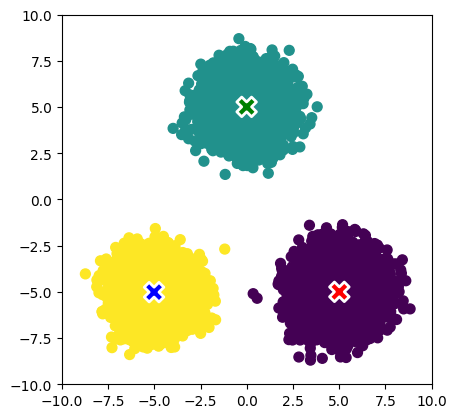

In [141]:
import matplotlib.pyplot as plt
plt.scatter(x_train[:, 0], x_train[:, 1], c=cluster, s=50)
plt.scatter(means[:, 0], means[:, 1], s=200, marker='X', lw=2, c=['red', 'green', 'blue'], edgecolor="white")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect("equal")
plt.show()

## General Expectation Maximization Algorithm

The goal of the EM algorithm is to find maximum likelihood solutions for models having latent variables.
The likelihood function is:

$$\ln p(X|\theta) = \ln \sum_{Z} p(X, Z|\theta)$$

where $X$ is the observed data, $Z$ is the latent variable, and $\theta$ is the parameter.
Typically, the joint distribution $p(X, Z|\theta)$ is easy to compute, but the marginal distribution $p(X|\theta)$ is difficult to compute, as in graphical models.


The above likelihood function can not be easily maxmized using closed-form solutions as in linear regression.
The reason is the summation over the latent variable $Z$ appears inside of a logarithm. Even the joint distribution $p(X, Z|\theta)$ is a simple exponential family distribution, the marginal distribution $p(X|\theta)$ does not as a result of this summation. 
The presence of the summation prevents the logarithm from acting directly on the joint distribution, resulting complex expressions for the maximum likelihood solution.

How to make this problem easier to solve?

The idea is to introduce a distribution $q(Z)$ over the latent variable $Z$, and maximize a lower bound on the log likelihood function. This lower bound is called the **evidence lower bound (ELBO)**.
Note since $q(Z)$ is a distribution, it must satisfy $\sum_Z q(Z) = 1$ and $q(Z) \ge 0$.

$$\ln p(X|\theta) = \ln p(X, Z|\theta) - \ln p(Z|X,\theta)$$
$$\ln p(X|\theta) = \mathcal{L} (q, \theta) + KL(q||p)$$
$$\mathcal{L}(q, \theta) = \sum_Z q(Z) \ln \frac{p(X,Z|\theta)}{q(Z)}$$
$$KL(p||q) = - \sum_Z q(Z) \ln \frac{p(Z|X, \theta)}{q(Z)}$$ 

where $\mathcal{L} (q, \theta)$ is the ELBO, and $KL(q||p)$ is the Kullback-Leibler divergence between $q(Z)$ and the true posterior $p(Z|X, \theta)$.
Note $KL(q||p) \ge 0$, therefore $\mathcal{L}(q, \theta)$ is a lower bound for the log likelihood function $\ln p(X|\theta)$. 

Therefore, the EM instead of maximizing the log likelihood function $\ln p(X|\theta)$, it maximizes the ELBO $\mathcal{L}(q, \theta)$.

The EM algorithm is a two-stage iterative optimization technique for finding maximum likelihood solutions.

In the E step, it finds the optimal distribution $q(Z)$ that maximizes the loglikehood $p(X|\theta)$, while holding the parameter $\theta$ fixed.
- The solution to this maximization is easy to obtain. 
- The log likelihood at this step $\ln p(X|\theta)$ does not depend on $\theta$ and so the largest value of $\mathcal{L}(q, \theta)$ will occur when the KL divergence vanishes, in other words, when $q(Z)$ equals to the latent variable's posterior $p(Z|X,\theta)$ 

In the M step, it maximizes the ELBO $\mathcal{L}(q, \theta)$ with respect to the parameter $\theta$, while holding the distribution $q(Z)$ fixed.
- this step causes the ELBO $\mathcal{L}(q, \theta)$ to increase, which will necessarily cause the log likehood function to increase.
- because the distribution $q$ is determined using the old parameter $\theta$ rather than the new value and is held fixed during M step, it will not equal the new posterior distribution $p(Z|X,\theta)$, and so the KL divergence will be nonzero.
- if we substitue $q(Z) = p(Z|X, \theta^{old})$ into the above equations, we can see that after the E step, the lower bound takes:

$$\mathcal{L}(q,\theta) = \sum_{Z} p(Z|X, \theta^{old})\ln p(X,Z|\theta) - \sum_Z p(Z|X, \theta^{old}) \ln p(Z|X, \theta^{old}) = \mathcal{Q}(\theta, \theta^{old}) + const$$

### EM algorithm

Given a joint distribution $p(X,Z|\theta)$ over observed variables $X$ and latent variables $Z$, governed by parameters $\theta$, the goal is to maximize the likelihood function $p(X|\theta)$ with respect to $\theta$.

1. choose an initial setting for the parameters $\theta^{old}$.
2. E step: evaluate the posterior distribution $p(Z|X, \theta^{old})$.
3. M step: evaluate the parameters $\theta^{new}$ that maximize the expected log likelihood found in the E step:
$$\theta^{new} = \arg \max_{\theta} \mathcal{Q}(\theta, \theta^{old})$$

        where the function $\mathcal{Q}$ is defined as:
$$\mathcal{Q}(\theta, \theta^{old}) = \sum_Z p(Z|X, \theta^{old}) \ln p(X, Z|\theta)$$

4. check for convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied, then let 
$$\theta^{old} \leftarrow \theta^{new}$$

        and return to step 2